<a href="https://colab.research.google.com/github/SabtheCrab/CS-175-Final-Project/blob/master/Copy_of_CS175_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 175 Final Project: Humback Whale Identification**

**Group Member 1:**

Name: Sabrina Will

**Group Member 2:**

Name: Jeffrey Lee Ye

CREDITS FOR BOUNDING BOX CROPPED DATASET: https://www.kaggle.com/josemontiel/humpback-whale-bounding-box-cropped-dataset/output

In [1]:
#We are using a data set, which originally came from the kaggle competition. However, many of the images suffered from misalignment issues and have 
#large amounts of background space we dont need our AI to consider when looking at whale flukes. As such, someone blessed competitors with a
#dataset that reformats all original images and crops out just the whale fluke itself. This is the data we are using in our project. 

from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#navigate to Final Project Directory
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project

/content/drive/My Drive/CS 175 Final Project


In [0]:
#navigate to data directory, and then test directory within it
%cd  /content/drive/My\ Drive/CS\ 175\ Final\ Project/data/test

/content/drive/My Drive/CS 175 Final Project/data/test


In [0]:
#navigate to data directory, and then train directory within it
%cd  /content/drive/My\ Drive/CS\ 175\ Final\ Project/data/train

/content/drive/My Drive/CS 175 Final Project/data/train


In [3]:
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

/content/drive/My Drive/CS 175 Final Project/data


In [82]:
import copy, cv2, json, os, time, torch, torchvision

from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
from PIL import Image
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import models
from torchvision import transforms
import torchvision.datasets as datasets

import pandas as pd

import seaborn as sns

df = pd.read_csv('train.csv')
testDf = pd.read_csv('sample_submission.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [5]:
df.columns

Index(['Image', 'Id'], dtype='object')

In [0]:
#credit to: https://github.com/AdityaSidharta/kaggle_humpback_whale/blob/master/humpback_whale.ipynb for plot_images function
def plot_images(filenames, table_size, labels = '', traintest = 'train'):
    imgs_filename = [traintest + '/' + str(filename) for filename in filenames]
    imgs = [plt.imread(filename) for filename in imgs_filename]
    figure = plt.figure(figsize=(20, 10))
    rows, cols = table_size
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if not np.all(labels == ''):
            subplot.set_title(labels[i], fontsize=10)
        subplot.imshow(imgs[i], cmap='gray')
    plt.tight_layout()
    plt.show()

/content/drive/My Drive/CS 175 Final Project/data/train/output/humpback-whale-identification-cropped


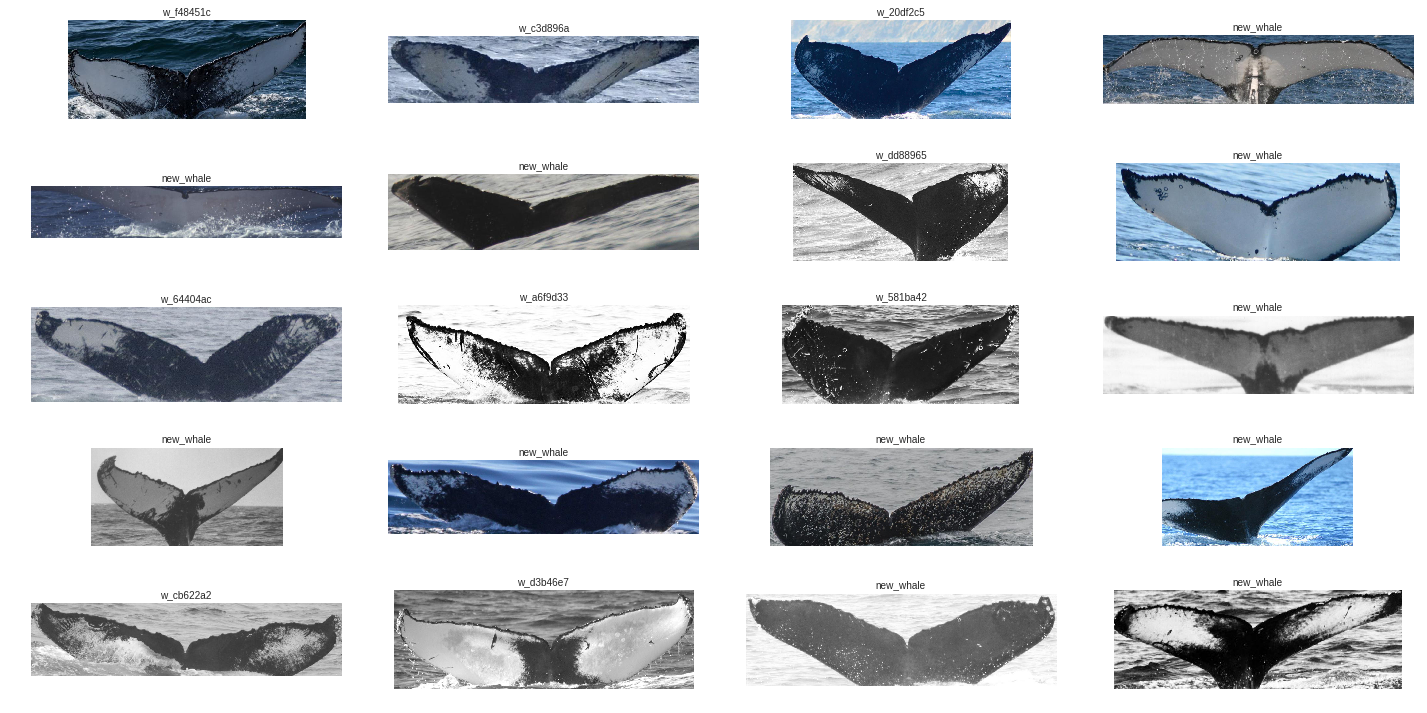

In [10]:
#showing random whale images to make sure i loaded in the data properly
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data/train/output/humpback-whale-identification-cropped/

plot_images(df.Image[:20], (5,4) ,df.Id[:20], 'train')

In [22]:
%cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

/content/drive/My Drive/CS 175 Final Project/data


In [12]:
#find number of unique whale individuals

n_unique = len(df['Id'].unique())
img_size = (200, 300, 1)

print ("Number of Unique Categories : " + str(n_unique))

Number of Unique Categories : 5005


In [13]:
n_train = len(df['Id'])
#counts of each unique whale
weight_series = df['Id'].value_counts()
weight_df = pd.DataFrame(weight_series)
weight_df.columns = ['count']
weight_df['count'] = weight_df['count'].astype(float)
weight_df['Id'] = weight_df.index
weight_df = weight_df.reset_index(drop = True)
weight_df['weight'] = n_train / (n_unique * weight_df['count'] )
label_to_idNum = dict(zip(weight_df['Id'], range(n_unique)))
weight_df

,count,Id,weight
0,9664.0,new_whale,0.000524
1,73.0,w_23a388d,0.069413
2,65.0,w_9b5109b,0.077956
3,62.0,w_9c506f6,0.081728
4,61.0,w_0369a5c,0.083068
5,57.0,w_700ebb4,0.088897
6,54.0,w_3de579a,0.093836
7,51.0,w_564a34b,0.099356
8,50.0,w_fd3e556,0.101343
9,49.0,w_88e4537,0.103411


Most classes only have a few to one image within them

In [15]:
total = len(df['Id'])
print(f'Total images in training set {total}')

Total images in training set 25361


In [0]:
class HumpbackWhale_Dataset(Dataset):
    def __init__(self,filepath, csv_path, transform=None):
        self.file_path = filepath
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.image_list = [x for x in os.listdir(self.file_path)]
        
    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.file_path,self.df.Image[idx])
        label = self.df.Id[idx]
        imgRGB = Image.open(img_path).convert('RGB')
        img = self.transform(imgRGB)
        imgName = self.df.Image[idx]
        return img, label, imgName


In [0]:
def label_to_id(label):
    x = [label_to_idNum[i] for i in label]
    return torch.tensor(x)

# Process a PIL image for use in a PyTorch model
def process_image(image):
    #img_transform = transforms.Compose([
#        transforms.ToTensor()])
    img_transform = transform
    pil_image = Image.open(image)
    pil_image = img_transform(pil_image).float()
    np_image = np.array(pil_image)    
    return np_image

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    return ax

In [20]:
#old 256
dims = 128

transform = transforms.Compose([
                              transforms.Resize((dims, dims)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

dim1 = max(int(dims**2/2),5005)
dim2 = max(int((dims**2)/4),5005)
print(dim1)
print(dim2)

8192
5005


In [87]:
train_dataset = HumpbackWhale_Dataset('train/output/humpback-whale-identification-cropped/train','train.csv', transform)
test_dataset = HumpbackWhale_Dataset('test/output/humpback-whale-identification-cropped/test','sample_submission.csv', transform)
print(len(train_dataset.image_list))
print(len(test_dataset.image_list))

25361
7960


In [24]:
train_dataset[0][0].size()

torch.Size([3, 128, 128])

In [25]:
# example
a = list(range(10))
b = list(range(5,15))
np.setdiff1d(a,b) #in a and not in b

array([0, 1, 2, 3, 4])

In [26]:
test_size = .2
n = len(train_dataset)

np.random.seed(0)
a = list(range(n))

train_index = np.random.choice(a,replace=False,size=int(n*(1-test_size)))
test_index = np.setdiff1d(a,train_index)
print(train_index.size)
print(test_index.size)


use_only = .5
train_cut_index = np.random.choice(train_index, replace=False, size=int(train_index.size * use_only))
test_cut_index = np.random.choice(test_index, replace=False, size=int(test_index.size * use_only))
print("cut size:")
print(train_cut_index.size)
print(test_cut_index.size)

20288
5073
cut size:
10144
2536


In [88]:
data_train = copy.deepcopy(train_dataset)
data_train.image_list = [train_dataset.image_list[i] for i in train_cut_index]

data_test = copy.deepcopy(train_dataset)
data_test.image_list = [train_dataset.image_list[i] for i in test_cut_index]

gen_train = DataLoader(data_train,batch_size=16, shuffle=True)
gen_test = DataLoader(data_test,batch_size=16, shuffle=True)
full_train_generator = DataLoader(train_dataset,batch_size=16, shuffle=True)
full_test_generator = DataLoader(test_dataset,batch_size=16, shuffle=True)

print(len(gen_train))
print(len(gen_test))
print(len(full_train_generator))
print(len(full_test_generator))

634
159
1586
498


In [28]:
print(len(train_dataset))
print(len(test_dataset))
print(len(data_train))
print(len(data_test))


25361
7960
10144
2536


In [39]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=5005):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(int(32*dims*dims/4/4), num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

print("Cuda" if torch.cuda.is_available() else "CPU")
  
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ConvNet(n_unique).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

Cuda


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# Load already created model
checkpoint = torch.load('checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

# can skip training if this node is run

In [41]:
# Train data on part of the full training data to check performance with
epochs = 8
# training_data = full_train_generator
training_data = gen_train

image_count = len(training_data)
progress_printer = 25

for e in range(epochs):
    running_loss, i = 0, 0

    for image, label, _ in training_data:
        label = label_to_id(label)
        image, label = image.to(device), label.to(device)
        i +=1 
        if i % progress_printer == 0:
            print('{:.0f}% complete'.format(i/image_count*100))
        log_ps = model(image)
        loss = criterion(log_ps, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print('epoch {}: loss: {}'.format(e,running_loss))

4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91% complete
95% complete
99% complete
epoch 0: loss: 4721.072352647781
4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91% complete
95% complete
99% complete
epoch 1: loss: 3240.3126850128174
4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91%

In [0]:
def testModel(model, testing_data):
    model.eval()
    with torch.no_grad():
      numCorrect = 0
      total = 0
      batch = 0 
      progress_printer = 25
      for image, label, _ in testing_data:
          label = label_to_id(label).to(device)
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5)
          #top5Pred, top5PredIndices = torch.topk(predicted, 1)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              numCorrect += (label[p] in currPred)
          total += len(label)
          if (batch % progress_printer == 0):
            print("NumCorrect:", numCorrect, "with total:", total, " (Batch", batch, ")")
          batch += 1
      return numCorrect / total

In [43]:
# Using calculated model with epoch 8
print(len(gen_train))
training_acc = testModel(model, gen_train)
print('Training acc:', training_acc)

634
NumCorrect: 16 with total: 16  (Batch 0 )
NumCorrect: 416 with total: 416  (Batch 25 )
NumCorrect: 816 with total: 816  (Batch 50 )
NumCorrect: 1216 with total: 1216  (Batch 75 )
NumCorrect: 1616 with total: 1616  (Batch 100 )
NumCorrect: 2016 with total: 2016  (Batch 125 )
NumCorrect: 2416 with total: 2416  (Batch 150 )
NumCorrect: 2816 with total: 2816  (Batch 175 )
NumCorrect: 3216 with total: 3216  (Batch 200 )
NumCorrect: 3616 with total: 3616  (Batch 225 )
NumCorrect: 4016 with total: 4016  (Batch 250 )
NumCorrect: 4416 with total: 4416  (Batch 275 )
NumCorrect: 4816 with total: 4816  (Batch 300 )
NumCorrect: 5216 with total: 5216  (Batch 325 )
NumCorrect: 5616 with total: 5616  (Batch 350 )
NumCorrect: 6016 with total: 6016  (Batch 375 )
NumCorrect: 6416 with total: 6416  (Batch 400 )
NumCorrect: 6815 with total: 6816  (Batch 425 )
NumCorrect: 7215 with total: 7216  (Batch 450 )
NumCorrect: 7615 with total: 7616  (Batch 475 )
NumCorrect: 8015 with total: 8016  (Batch 500 )
N

In [44]:
# Using loaded model
loaded_model = ConvNet(n_unique).to(device)
# Load already created model
checkpoint = torch.load('checkpoint.pth.tar')
loaded_model.load_state_dict(checkpoint['state_dict'])

# can skip training if this node is run

print(len(gen_train))
training_acc = testModel(loaded_model, gen_train)
print('Training acc:', training_acc)

634
NumCorrect: 6 with total: 16  (Batch 0 )
NumCorrect: 168 with total: 416  (Batch 25 )
NumCorrect: 342 with total: 816  (Batch 50 )
NumCorrect: 527 with total: 1216  (Batch 75 )
NumCorrect: 701 with total: 1616  (Batch 100 )
NumCorrect: 877 with total: 2016  (Batch 125 )
NumCorrect: 1044 with total: 2416  (Batch 150 )
NumCorrect: 1211 with total: 2816  (Batch 175 )
NumCorrect: 1392 with total: 3216  (Batch 200 )
NumCorrect: 1567 with total: 3616  (Batch 225 )
NumCorrect: 1743 with total: 4016  (Batch 250 )
NumCorrect: 1904 with total: 4416  (Batch 275 )
NumCorrect: 2085 with total: 4816  (Batch 300 )
NumCorrect: 2257 with total: 5216  (Batch 325 )
NumCorrect: 2430 with total: 5616  (Batch 350 )
NumCorrect: 2601 with total: 6016  (Batch 375 )
NumCorrect: 2769 with total: 6416  (Batch 400 )
NumCorrect: 2950 with total: 6816  (Batch 425 )
NumCorrect: 3142 with total: 7216  (Batch 450 )
NumCorrect: 3306 with total: 7616  (Batch 475 )
NumCorrect: 3505 with total: 8016  (Batch 500 )
NumCo

In [45]:
print(len(gen_test))
test_acc = testModel(model, gen_test)
print('Test acc:', test_acc)

159
NumCorrect: 16 with total: 16  (Batch 0 )
NumCorrect: 416 with total: 416  (Batch 25 )
NumCorrect: 816 with total: 816  (Batch 50 )
NumCorrect: 1216 with total: 1216  (Batch 75 )
NumCorrect: 1616 with total: 1616  (Batch 100 )
NumCorrect: 2016 with total: 2016  (Batch 125 )
NumCorrect: 2416 with total: 2416  (Batch 150 )
Test acc: 1.0


In [0]:
epochs = 15
epoch = []
loss_list = []
# training_data = full_train_generator
training_data = gen_train

image_count = len(training_data)
progress_printer = 25

for e in range(epochs):
    running_loss, i = 0, 0

    for image, label, _ in training_data:
        label = label_to_id(label)
        image, label = image.to(device), label.to(device)
        i +=1 
        if i % progress_printer == 0:
            print('{:.0f}% complete'.format(i/image_count*100))
        log_ps = model(image)
        loss = criterion(log_ps, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print('epoch {}: loss: {}'.format(e,running_loss))
    epoch.append(e)
    loss_list.append(running_loss)

4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91% complete
95% complete
99% complete
epoch 0: loss: 4994.79052901268
4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91% complete
95% complete
99% complete
epoch 1: loss: 2918.7390537261963
4% complete
8% complete
12% complete
16% complete
20% complete
24% complete
28% complete
32% complete
35% complete
39% complete
43% complete
47% complete
51% complete
55% complete
59% complete
63% complete
67% complete
71% complete
75% complete
79% complete
83% complete
87% complete
91% 

Text(0, 0.5, 'loss')

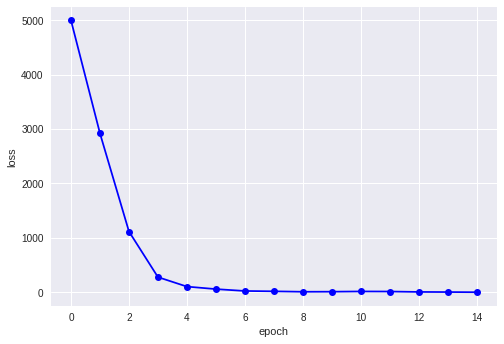

In [0]:
plt.figure()
plt.plot(epoch,loss_list,'-ob')
plt.xlabel('epoch')
plt.ylabel('loss')

In [0]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint2.pth.tar')

In [0]:
def testModel(model, testing_data):
    model.eval()
    with torch.no_grad():
      numCorrect = 0
      total = 0
      batch = 0 
      progress_printer = 25
      for image, label, _ in testing_data:
          label = label_to_id(label).to(device)
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5)
          #top5Pred, top5PredIndices = torch.topk(predicted, 1)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              numCorrect += (label[p] in currPred)
          total += len(label)
          batch += 1
          if (batch % progress_printer == 0):
            print("NumCorrect:", numCorrect, "with total:", total, " (Batch", batch, ")")
      return numCorrect / total

In [0]:
print(len(gen_train))
training_acc = testModel(model, gen_train)
print('Training acc:', training_acc)

634
NumCorrect: 400 with total: 400  (Batch 25 )
NumCorrect: 800 with total: 800  (Batch 50 )
NumCorrect: 1200 with total: 1200  (Batch 75 )
NumCorrect: 1600 with total: 1600  (Batch 100 )
NumCorrect: 2000 with total: 2000  (Batch 125 )
NumCorrect: 2400 with total: 2400  (Batch 150 )
NumCorrect: 2800 with total: 2800  (Batch 175 )
NumCorrect: 3200 with total: 3200  (Batch 200 )
NumCorrect: 3600 with total: 3600  (Batch 225 )
NumCorrect: 4000 with total: 4000  (Batch 250 )
NumCorrect: 4400 with total: 4400  (Batch 275 )
NumCorrect: 4800 with total: 4800  (Batch 300 )
NumCorrect: 5200 with total: 5200  (Batch 325 )
NumCorrect: 5600 with total: 5600  (Batch 350 )
NumCorrect: 6000 with total: 6000  (Batch 375 )
NumCorrect: 6400 with total: 6400  (Batch 400 )
NumCorrect: 6800 with total: 6800  (Batch 425 )
NumCorrect: 7200 with total: 7200  (Batch 450 )
NumCorrect: 7600 with total: 7600  (Batch 475 )
NumCorrect: 8000 with total: 8000  (Batch 500 )
NumCorrect: 8400 with total: 8400  (Batch 5

In [0]:
print(len(gen_test))
test_acc = testModel(model, gen_test)
print('Test acc:', test_acc)

159
NumCorrect: 400 with total: 400  (Batch 25 )
NumCorrect: 800 with total: 800  (Batch 50 )
NumCorrect: 1200 with total: 1200  (Batch 75 )
NumCorrect: 1600 with total: 1600  (Batch 100 )
NumCorrect: 2000 with total: 2000  (Batch 125 )
NumCorrect: 2400 with total: 2400  (Batch 150 )
Test acc: 1.0


In [0]:
torch.save(model, '2CNN_model')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model = torch.load('2CNN_model')

In [0]:
def predict(model, testing_data, sample_only=False):
    image_list = copy.deepcopy(test_dataset.image_list)
    predictions = []
    jpg = []
    lenTest = len(testing_data) * 1.0
    progress_print = 10
    for index, (image, label, imageName) in enumerate(testing_data):
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              currPred.cpu()
              relabel_whaleid = []
              for i in currPred:          
                  relabel_whaleid.append(weight_df.loc[int(i),'Id'])
              jpg.append(label[p] + '.jpg')
              predictions.append(' '.join(relabel_whaleid))     
          if index % progress_print == 0:
            print(f'{index / lenTest * 100}%')
          if sample_only:
            break;
    
    whale_predictions = pd.DataFrame({'Image':jpg,'Id':predictions})
    return whale_predictions          

In [0]:
def predictTest(model, testing_data, sample_only=False):
    image_list = copy.deepcopy(test_dataset.image_list)
    predictions = []
    jpg = []
    lenTest = len(testing_data) * 1.0
    progress_print = 10
    for index, (image, label, imageName) in enumerate(testing_data):
          image = image.to(device)
          predicted = model(image)
          top5Pred, top5PredIndices = torch.topk(predicted, 5)
          for p in range(len(top5PredIndices)):
              currPred = top5PredIndices[p]
              currPred.cpu()
              relabel_whaleid = []
              for i in currPred:          
                  relabel_whaleid.append(weight_df.loc[int(i),'Id'])
              jpg.append(imageName[p])
              predictions.append(' '.join(relabel_whaleid))  
          if index % progress_print == 0:
            print(f'{index / lenTest * 100}%')
          if sample_only:
            break;
    
    whale_predictions = pd.DataFrame({'Image':jpg,'Id':predictions})
    return whale_predictions          

In [116]:
#image_list = copy.deepcopy(full_train_generator)
#print(len(full_train_generator)
print(len(full_test_generator))
test_predictions = predictTest(model, full_test_generator, False)
# test_test_predictions = predictTest(model, full_test_generator, True)
print(len(gen_test))
# test_acc = predict(model, gen_test, True)



498
0.0%
2.0080321285140563%
4.016064257028113%
6.024096385542169%
8.032128514056225%
10.040160642570282%
12.048192771084338%
14.056224899598394%
16.06425702811245%
18.072289156626507%
20.080321285140563%
22.08835341365462%
24.096385542168676%
26.104417670682732%
28.11244979919679%
30.120481927710845%
32.1285140562249%
34.13654618473896%
36.144578313253014%
38.152610441767074%
40.16064257028113%
42.168674698795186%
44.17670682730924%
46.1847389558233%
48.19277108433735%
50.20080321285141%
52.208835341365464%
54.21686746987952%
56.22489959839358%
58.23293172690763%
60.24096385542169%
62.24899598393574%
64.2570281124498%
66.26506024096386%
68.27309236947792%
70.28112449799197%
72.28915662650603%
74.29718875502009%
76.30522088353415%
78.3132530120482%
80.32128514056225%
82.32931726907631%
84.33734939759037%
86.34538152610442%
88.35341365461848%
90.36144578313254%
92.3694779116466%
94.37751004016064%
96.3855421686747%
98.39357429718876%
159


In [50]:
print(test_acc.shape)
test_acc = test_acc[test_acc.columns[::-1]]
print(test_acc)
test_acc.head()


(16, 2)
            Image                                                 Id
0   w_4a28f21.jpg  w_4a28f21 new_whale w_d405854 w_9d56f22 w_04003e9
1   w_dfb57cc.jpg  w_dfb57cc new_whale w_5e8e218 w_3815890 w_88e4537
2   w_2964e0b.jpg  w_2964e0b new_whale w_e1ffbe2 w_5e8e218 w_f0eddab
3   w_066ddc5.jpg  w_066ddc5 w_3815890 new_whale w_f0eddab w_c55c51d
4   w_14ece76.jpg  w_14ece76 new_whale w_7e579dd w_d947e85 w_307e5e9
5   w_fec5547.jpg  w_fec5547 w_80124ae new_whale w_e01ca20 w_e71f9c7
6   w_dd944b7.jpg  w_dd944b7 new_whale w_9b5109b w_0a155b9 w_b1f637e
7   new_whale.jpg  new_whale w_90c9763 w_4516d31 w_4ff2f4a w_27a6304
8   w_f74a89e.jpg  w_f74a89e new_whale w_2b069ba w_e1ffbe2 w_9d86594
9   w_f0fe284.jpg  w_f0fe284 new_whale w_f765256 w_c8d5ad5 w_d066f46
10  w_7a4b2f9.jpg  w_7a4b2f9 new_whale w_e2a09d4 w_2365d55 w_a9304b9
11  new_whale.jpg  new_whale w_0a155b9 w_9b5109b w_ae8982d w_0abdaf4
12  w_6ed6320.jpg  w_6ed6320 new_whale w_5c51475 w_2f1488c w_34120de
13  w_b3ca4b7.jpg  w_b3ca4

,Image,Id
0,w_4a28f21.jpg,w_4a28f21 new_whale w_d405854 w_9d56f22 w_04003e9
1,w_dfb57cc.jpg,w_dfb57cc new_whale w_5e8e218 w_3815890 w_88e4537
2,w_2964e0b.jpg,w_2964e0b new_whale w_e1ffbe2 w_5e8e218 w_f0eddab
3,w_066ddc5.jpg,w_066ddc5 w_3815890 new_whale w_f0eddab w_c55c51d
4,w_14ece76.jpg,w_14ece76 new_whale w_7e579dd w_d947e85 w_307e5e9


In [113]:
test_test_predictions = test_test_predictions[test_test_predictions.columns[::-1]]
print(test_test_predictions)

            Image                                                 Id
0   fe2d0e1c9.jpg  new_whale w_591a2c5 w_1f0cf0a w_bc285a6 w_343f088
1   75199483a.jpg  new_whale w_5597026 w_c875e45 w_9a1a810 w_2ed0acc
2   b994a2b0f.jpg  new_whale w_647da1f w_0fdf741 w_6caff0f w_7fe4082
3   79061b1bb.jpg  new_whale w_853aa18 w_d405854 w_a113b33 w_30f2f0f
4   edcccc188.jpg  w_9d56f22 new_whale w_f765256 w_997cda5 w_778e474
5   be9004d7b.jpg  new_whale w_518a722 w_12cc52d w_6fce84d w_9c68fe8
6   7b635e279.jpg  new_whale w_88e4537 w_a4140a6 w_dea40e2 w_bd4e5dd
7   41508a65c.jpg  new_whale w_60ce6fc w_9c506f6 w_488865e w_a9304b9
8   65f637a56.jpg  new_whale w_778e474 w_efbdcbc w_584e1dc w_e936b45
9   b7f522539.jpg  new_whale w_cbb15d2 w_efbdcbc w_23a388d w_04003e9
10  dcb501be7.jpg  new_whale w_d602efb w_4ff2f4a w_700ebb4 w_591a2c5
11  25700d220.jpg  new_whale w_6301785 w_fd3e556 w_3815890 w_9b171a8
12  86bdbaa57.jpg  new_whale w_26c0ffd w_9b5109b w_ae393cd w_263fcb0
13  702c05d67.jpg  new_whale w_11f

In [0]:
!cd /content/drive/My\ Drive/CS\ 175\ Final\ Project/data

In [127]:
print(test_predictions.shape)
test_predictions = test_predictions[test_predictions.columns[::-1]]
print(test_predictions)

test_predictions.to_csv('submission.csv', index=False)

(7960, 2)
              Image                                                 Id
0     86934f4c8.jpg  new_whale w_003bae6 w_a8b34a0 w_2964e0b w_83b2336
1     de2dc7980.jpg  new_whale w_343f088 w_40a8585 w_700ebb4 w_0369a5c
2     a34796b17.jpg  new_whale w_17b0d3a w_7c27fbd w_dea40e2 w_91cc02c
3     4d84f7105.jpg  new_whale w_b9e5911 w_b96391f w_30f2f0f w_f4f3715
4     d347a68fc.jpg  new_whale w_6f0cbe3 w_191bce3 w_f0fe284 w_a059841
5     d56723bd6.jpg  new_whale w_16df050 w_e4502b3 w_0bc078c w_c8bbb43
6     45108afa4.jpg  new_whale w_4846b27 w_939a97b w_ef83760 w_5597026
7     06c46df18.jpg  new_whale w_d6ca28d w_0a155b9 w_9b5109b w_8a1b71c
8     2ec63abe5.jpg  new_whale w_cd4cb49 w_d066c0a w_ae8982d w_0369a5c
9     1bf6235ba.jpg  new_whale w_47d86e8 w_3de579a w_92f4498 w_c0d8dcd
10    264afc332.jpg  new_whale w_5a2634c w_ddb62c2 w_32da935 w_db3cfa4
11    2a8457c08.jpg  new_whale w_2745292 w_a76f0b7 w_f61b957 w_10f67bb
12    58605935e.jpg  new_whale w_6525e6b w_3002b59 w_6a95be3 w_518a